# Model Evaluation & Comparison

Compare Random Forest predictions with:
- **WorldCover 2021** (ESA satellite-derived land cover)
- **OSM** (OpenStreetMap crowd-sourced green spaces)
- **NDVI Filter** (simple vegetation index threshold)

Metrics: Accuracy, Precision, Recall, F1-Score, IoU

In [19]:
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.mask import mask as rio_mask
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, jaccard_score
)
from scipy.ndimage import median_filter
import joblib
import os
import pandas as pd

print("Libraries loaded!")

Libraries loaded!


## 1. Configuration

In [20]:
# Test city (excluded from training)
CITY = "London"

# Base paths - using relative paths from project root
# Run notebooks from the project root directory
import os

# Find project root (go up from notebooks/evaluation/)
if os.path.exists("data") and os.path.exists("models"):
    PROJECT_ROOT = os.getcwd()
elif os.path.exists("../../data") and os.path.exists("../../models"):
    PROJECT_ROOT = os.path.abspath("../..")
else:
    PROJECT_ROOT = os.getcwd()
    print(f"Warning: Could not detect project root. Using: {PROJECT_ROOT}")

# Derived paths
DATA_PATH = os.path.join(PROJECT_ROOT, "data")
MODELS_PATH = os.path.join(PROJECT_ROOT, "models")

# Model and data paths
MODEL_PATH = os.path.join(MODELS_PATH, "random_forest_model.pkl")
SCALER_PATH = os.path.join(MODELS_PATH, "feature_scaler.pkl")
STACK_PATH = os.path.join(DATA_PATH, "sentinel_stacks", f"{CITY}_MultiMonth_stack.tif")
WORLDCOVER_PATH = os.path.join(DATA_PATH, "worldcover", f"{CITY}_WorldCover_2021.tif")
OSM_PATH = os.path.join(DATA_PATH, "sentinel_raw", CITY, f"{CITY}_OSM_labels.tif")
AOI_PATH = os.path.join(DATA_PATH, "aois", f"{CITY}.geojson")

# Output folder
OUTPUT_FOLDER = os.path.join(PROJECT_ROOT, "outputs", "evaluation_results", CITY)
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Prediction settings
PREDICTION_THRESHOLD = 0.55  # Probability threshold for RF
NDVI_THRESHOLD = 0.3  # Threshold for green filter
APPLY_SMOOTHING = True  # Apply median filter to remove noise

# WorldCover green classes
GREEN_CLASSES = [10, 20, 30]  # Tree, Shrubland, Grassland

print(f"Evaluating: {CITY}")
print(f"Project root: {PROJECT_ROOT}")
print(f"Data path: {DATA_PATH}")
print(f"Models path: {MODELS_PATH}")
print(f"Output folder: {OUTPUT_FOLDER}")

Evaluating: London
Project root: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city
Data path: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/data
Models path: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/models
Output folder: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/outputs/evaluation_results/London


## 2. Load Model and Data

In [21]:
# Load trained model and scaler
print("Loading model and scaler...")
model = joblib.load(MODEL_PATH)
scaler = joblib.load(SCALER_PATH)
print(f"  Model: {type(model).__name__}")
print(f"  Scaler: {type(scaler).__name__}")

# Load AOI
aoi_gdf = gpd.read_file(AOI_PATH)

Loading model and scaler...
  Model: RandomForestClassifier
  Scaler: StandardScaler


In [22]:
# Load Sentinel-2 stack
print(f"\nLoading Sentinel-2 stack for {CITY}...")
with rasterio.open(STACK_PATH) as src:
    X_stack = src.read()
    profile = src.profile.copy()
    transform = src.transform
    crs = src.crs

n_bands, height, width = X_stack.shape
print(f"  Shape: {X_stack.shape} ({n_bands} bands, {height}x{width} pixels)")


Loading Sentinel-2 stack for London...
  Shape: (21, 512, 512) (21 bands, 512x512 pixels)


In [23]:
# Load WorldCover and reproject to match Sentinel-2
print(f"\nLoading WorldCover...")
with rasterio.open(WORLDCOVER_PATH) as src:
    wc_data = src.read(1)
    wc_transform = src.transform
    wc_crs = src.crs

worldcover = np.empty((height, width), dtype=np.uint8)
reproject(
    source=wc_data,
    destination=worldcover,
    src_transform=wc_transform,
    src_crs=wc_crs,
    dst_transform=transform,
    dst_crs=crs,
    resampling=Resampling.nearest
)

# Binary green mask
worldcover_green = np.isin(worldcover, GREEN_CLASSES).astype(np.uint8)
wc_pct = 100 * worldcover_green.sum() / worldcover_green.size
print(f"  WorldCover green: {wc_pct:.2f}%")


Loading WorldCover...
  WorldCover green: 20.99%


In [24]:
# Load OSM labels
print(f"\nLoading OSM labels...")
if os.path.exists(OSM_PATH):
    with rasterio.open(OSM_PATH) as src:
        osm_labels = src.read(1)
    
    # Reproject if needed
    if osm_labels.shape != (height, width):
        osm_reproj = np.empty((height, width), dtype=np.uint8)
        with rasterio.open(OSM_PATH) as src:
            reproject(
                source=src.read(1),
                destination=osm_reproj,
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=crs,
                resampling=Resampling.nearest
            )
        osm_labels = osm_reproj
    
    osm_pct = 100 * osm_labels.sum() / osm_labels.size
    print(f"  OSM green: {osm_pct:.2f}%")
else:
    print("  OSM labels not found!")
    osm_labels = None


Loading OSM labels...
  OSM green: 17.86%


## 3. Generate Predictions

In [25]:
# Random Forest Prediction
print("\nGenerating RF prediction...")

# Reshape for prediction
X_flat = X_stack.reshape(n_bands, -1).T

# Handle NaN values
valid_mask = ~np.isnan(X_flat).any(axis=1)
X_valid = X_flat[valid_mask]

# Apply scaler
X_valid_scaled = scaler.transform(X_valid)

# Predict with probability threshold
y_proba = model.predict_proba(X_valid_scaled)
y_pred_valid = (y_proba[:, 1] >= PREDICTION_THRESHOLD).astype(int)

# Reconstruct full map
rf_prediction = np.full(height * width, np.nan)
rf_prediction[valid_mask] = y_pred_valid
rf_prediction = rf_prediction.reshape(height, width)

# Apply smoothing
if APPLY_SMOOTHING:
    nan_mask = np.isnan(rf_prediction)
    temp_map = np.where(nan_mask, 0, rf_prediction).astype(np.float32)
    temp_filtered = median_filter(temp_map, size=3)
    rf_prediction = np.where(nan_mask, np.nan, np.round(temp_filtered))

rf_pct = 100 * np.nansum(rf_prediction == 1) / np.sum(~np.isnan(rf_prediction))
print(f"  RF prediction green: {rf_pct:.2f}%")


Generating RF prediction...


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.3s


  RF prediction green: 22.76%


[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    1.6s finished


In [26]:
# NDVI Green Filter
print("\nCalculating NDVI Green Filter...")

def calculate_ndvi(nir, red):
    nir = nir.astype(float)
    red = red.astype(float)
    return (nir - red) / (nir + red + 1e-8)

# Band indices for 21-band stack:
# April: 0-6 (B02, B03, B04, B08, NDVI, EVI, SAVI)
# August: 7-13
# November: 14-20
# B08 (NIR) at indices 3, 10, 17; B04 (Red) at indices 2, 9, 16

ndvi_april = calculate_ndvi(X_stack[3], X_stack[2])
ndvi_august = calculate_ndvi(X_stack[10], X_stack[9])
ndvi_november = calculate_ndvi(X_stack[17], X_stack[16])

ndvi_mean = np.nanmean(np.stack([ndvi_april, ndvi_august, ndvi_november]), axis=0)
green_filter = (ndvi_mean > NDVI_THRESHOLD).astype(np.uint8)

gf_pct = 100 * green_filter.sum() / green_filter.size
print(f"  Green Filter (NDVI > {NDVI_THRESHOLD}): {gf_pct:.2f}%")


Calculating NDVI Green Filter...
  Green Filter (NDVI > 0.3): 14.08%


## 4. Calculate Metrics

In [27]:
def calculate_metrics(y_true, y_pred, name):
    """Calculate classification metrics."""
    # Flatten and remove NaN
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    valid = ~(np.isnan(y_true_flat) | np.isnan(y_pred_flat))
    y_true_clean = y_true_flat[valid].astype(int)
    y_pred_clean = y_pred_flat[valid].astype(int)
    
    metrics = {
        'Method': name,
        'Accuracy': accuracy_score(y_true_clean, y_pred_clean),
        'Precision': precision_score(y_true_clean, y_pred_clean, zero_division=0),
        'Recall': recall_score(y_true_clean, y_pred_clean, zero_division=0),
        'F1-Score': f1_score(y_true_clean, y_pred_clean, zero_division=0),
        'IoU (Jaccard)': jaccard_score(y_true_clean, y_pred_clean, zero_division=0),
        'Green %': 100 * y_pred_clean.sum() / len(y_pred_clean),
        'GT Green %': 100 * y_true_clean.sum() / len(y_true_clean),
        'Diff %': 100 * (y_pred_clean.sum() - y_true_clean.sum()) / len(y_true_clean)
    }
    
    return metrics, confusion_matrix(y_true_clean, y_pred_clean)

In [28]:
# Calculate metrics for each comparison
results = []
confusion_matrices = {}

# RF vs WorldCover
metrics_rf_wc, cm_rf_wc = calculate_metrics(worldcover_green, rf_prediction, 'RF vs WorldCover')
results.append(metrics_rf_wc)
confusion_matrices['RF vs WorldCover'] = cm_rf_wc

# Green Filter vs WorldCover
metrics_gf_wc, cm_gf_wc = calculate_metrics(worldcover_green, green_filter, 'GreenFilter vs WorldCover')
results.append(metrics_gf_wc)
confusion_matrices['GreenFilter vs WorldCover'] = cm_gf_wc

# RF vs OSM (if available)
if osm_labels is not None:
    metrics_rf_osm, cm_rf_osm = calculate_metrics(osm_labels, rf_prediction, 'RF vs OSM')
    results.append(metrics_rf_osm)
    confusion_matrices['RF vs OSM'] = cm_rf_osm
    
    # Green Filter vs OSM
    metrics_gf_osm, cm_gf_osm = calculate_metrics(osm_labels, green_filter, 'GreenFilter vs OSM')
    results.append(metrics_gf_osm)
    confusion_matrices['GreenFilter vs OSM'] = cm_gf_osm
    
    # WorldCover vs OSM
    metrics_wc_osm, cm_wc_osm = calculate_metrics(osm_labels, worldcover_green, 'WorldCover vs OSM')
    results.append(metrics_wc_osm)
    confusion_matrices['WorldCover vs OSM'] = cm_wc_osm

# Create DataFrame
df_results = pd.DataFrame(results)
print(df_results.to_string(index=False))

                   Method  Accuracy  Precision   Recall  F1-Score  IoU (Jaccard)   Green %  GT Green %    Diff %
         RF vs WorldCover  0.945848   0.842431 0.912890  0.876246       0.779750 22.757275   21.000813  1.756462
GreenFilter vs WorldCover  0.917484   0.952244 0.638908  0.764724       0.619072 14.082718   20.989227 -6.906509
                RF vs OSM  0.895032   0.662081 0.842973  0.741657       0.589391 22.757275   17.873845  4.883431
       GreenFilter vs OSM  0.909988   0.814638 0.642236  0.718237       0.560350 14.082718   17.863083 -3.780365
        WorldCover vs OSM  0.894001   0.673022 0.790804  0.727175       0.571307 20.989227   17.863083  3.126144


In [29]:
# Save metrics to CSV
df_results.to_csv(os.path.join(OUTPUT_FOLDER, 'metrics_comparison.csv'), index=False)
print(f"\nMetrics saved to: {OUTPUT_FOLDER}/metrics_comparison.csv")


Metrics saved to: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/outputs/evaluation_results/London/metrics_comparison.csv


## 5. Visualizations

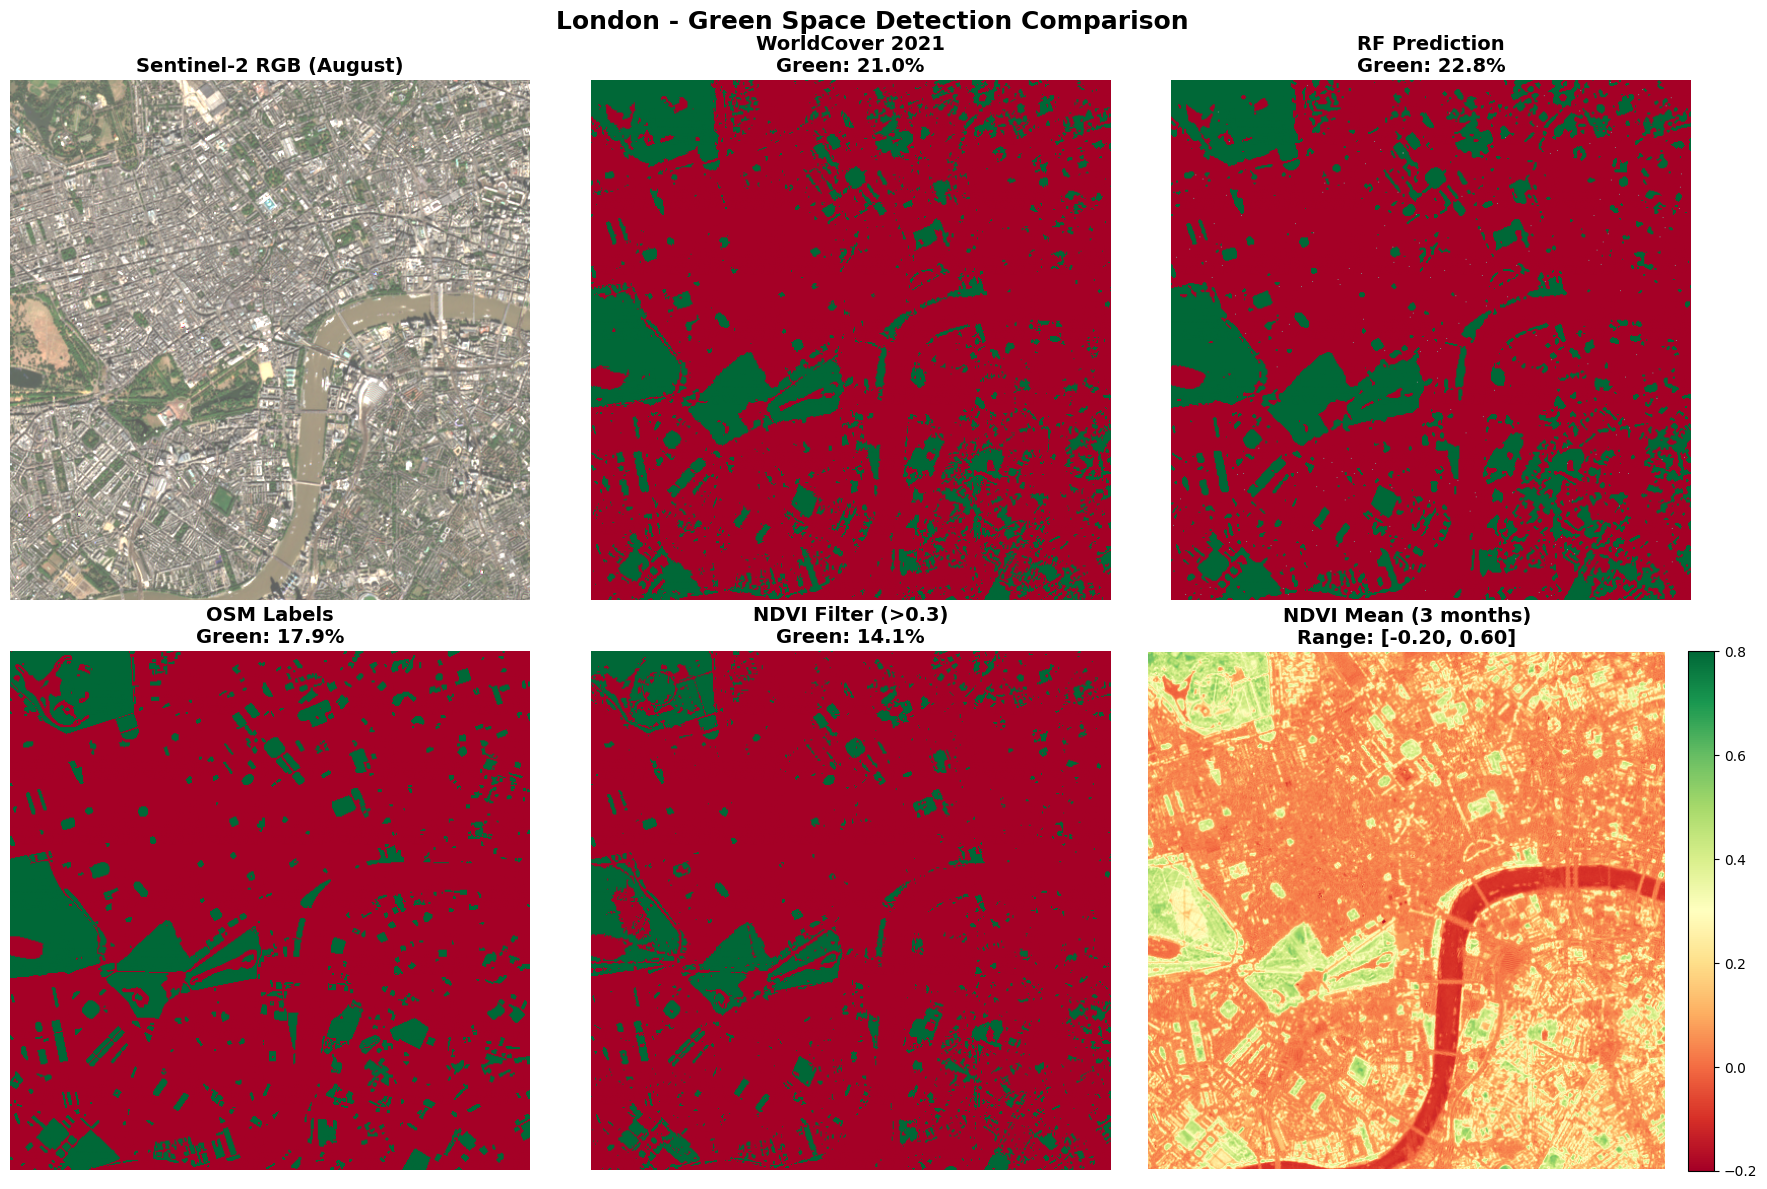

In [30]:
# 6-Panel Comparison: 2 rows x 3 columns
# Row 1: RGB | WorldCover | RF Prediction
# Row 2: OSM | NDVI Filter | NDVI Heatmap
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Prepare RGB
rgb = X_stack[[9, 8, 7], :, :].transpose(1, 2, 0)
rgb_norm = np.clip(rgb / 3000, 0, 1)

# Prepare masked RF
cmap_rf = plt.cm.RdYlGn.copy()
cmap_rf.set_bad(color='gray')
rf_masked = np.ma.masked_invalid(rf_prediction)

# Row 1
# 1. RGB (August)
axes[0, 0].imshow(rgb_norm)
axes[0, 0].set_title('Sentinel-2 RGB (August)', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

# 2. WorldCover
axes[0, 1].imshow(worldcover_green, cmap='RdYlGn', vmin=0, vmax=1)
axes[0, 1].set_title(f'WorldCover 2021\nGreen: {wc_pct:.1f}%', fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

# 3. RF Prediction
axes[0, 2].imshow(rf_masked, cmap=cmap_rf, vmin=0, vmax=1)
axes[0, 2].set_title(f'RF Prediction\nGreen: {rf_pct:.1f}%', fontsize=14, fontweight='bold')
axes[0, 2].axis('off')

# Row 2
# 4. OSM
if osm_labels is not None:
    axes[1, 0].imshow(osm_labels, cmap='RdYlGn', vmin=0, vmax=1)
    axes[1, 0].set_title(f'OSM Labels\nGreen: {osm_pct:.1f}%', fontsize=14, fontweight='bold')
else:
    axes[1, 0].text(0.5, 0.5, 'OSM not available', ha='center', va='center', 
                    transform=axes[1, 0].transAxes, fontsize=14)
axes[1, 0].axis('off')

# 5. NDVI Filter
axes[1, 1].imshow(green_filter, cmap='RdYlGn', vmin=0, vmax=1)
axes[1, 1].set_title(f'NDVI Filter (>{NDVI_THRESHOLD})\nGreen: {gf_pct:.1f}%', fontsize=14, fontweight='bold')
axes[1, 1].axis('off')

# 6. NDVI Heatmap
im = axes[1, 2].imshow(ndvi_mean, cmap='RdYlGn', vmin=-0.2, vmax=0.8)
axes[1, 2].set_title(f'NDVI Mean (3 months)\nRange: [{np.nanmin(ndvi_mean):.2f}, {np.nanmax(ndvi_mean):.2f}]', 
                     fontsize=14, fontweight='bold')
axes[1, 2].axis('off')
plt.colorbar(im, ax=axes[1, 2], fraction=0.046, pad=0.04)

plt.suptitle(f'{CITY} - Green Space Detection Comparison', fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, 'comparison_6panel.png'), dpi=300, bbox_inches='tight')
plt.show()

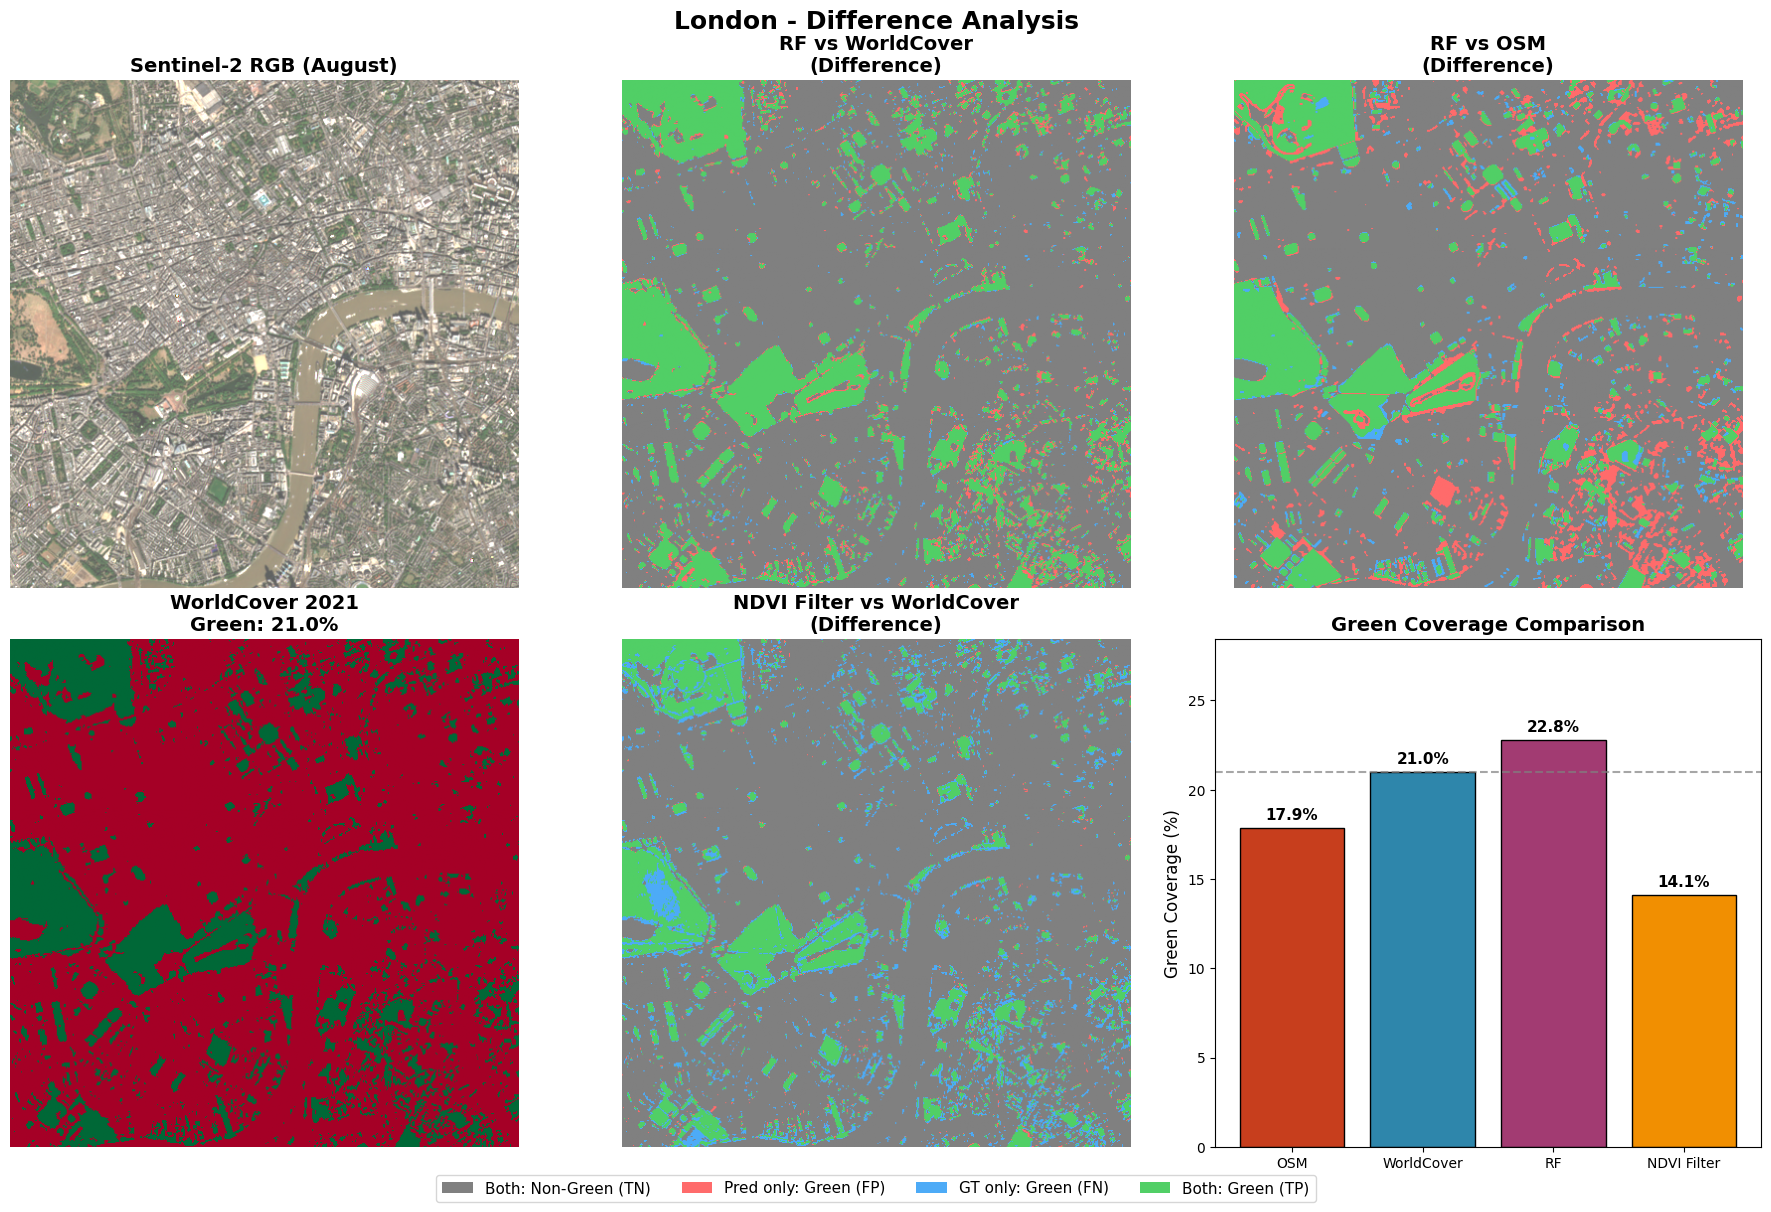

In [31]:
# Alternative view: Difference maps in 2x3 grid
# Row 1: RGB | RF vs WorldCover diff | RF vs OSM diff
# Row 2: WorldCover | NDVI vs WorldCover diff | Green coverage comparison
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Create difference maps function
def create_diff_map(pred, gt):
    pred = np.nan_to_num(pred, nan=0).astype(int)
    gt = gt.astype(int)
    diff = np.zeros_like(pred)
    diff[(pred == 0) & (gt == 0)] = 0  # True Negative (gray)
    diff[(pred == 1) & (gt == 0)] = 1  # False Positive (red)
    diff[(pred == 0) & (gt == 1)] = 2  # False Negative (blue)
    diff[(pred == 1) & (gt == 1)] = 3  # True Positive (green)
    return diff

# Custom colormap: gray, red, blue, green
from matplotlib.colors import ListedColormap
diff_cmap = ListedColormap(['#808080', '#FF6B6B', '#4DABF7', '#51CF66'])

# Row 1
# 1. RGB
axes[0, 0].imshow(rgb_norm)
axes[0, 0].set_title('Sentinel-2 RGB (August)', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

# 2. RF vs WorldCover difference
diff_rf_wc = create_diff_map(rf_prediction, worldcover_green)
axes[0, 1].imshow(diff_rf_wc, cmap=diff_cmap, vmin=0, vmax=3)
axes[0, 1].set_title('RF vs WorldCover\n(Difference)', fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

# 3. RF vs OSM difference
if osm_labels is not None:
    diff_rf_osm = create_diff_map(rf_prediction, osm_labels)
    axes[0, 2].imshow(diff_rf_osm, cmap=diff_cmap, vmin=0, vmax=3)
    axes[0, 2].set_title('RF vs OSM\n(Difference)', fontsize=14, fontweight='bold')
else:
    axes[0, 2].text(0.5, 0.5, 'OSM not available', ha='center', va='center', 
                    transform=axes[0, 2].transAxes, fontsize=14)
axes[0, 2].axis('off')

# Row 2
# 4. WorldCover
axes[1, 0].imshow(worldcover_green, cmap='RdYlGn', vmin=0, vmax=1)
axes[1, 0].set_title(f'WorldCover 2021\nGreen: {wc_pct:.1f}%', fontsize=14, fontweight='bold')
axes[1, 0].axis('off')

# 5. NDVI Filter vs WorldCover difference
diff_gf_wc = create_diff_map(green_filter, worldcover_green)
axes[1, 1].imshow(diff_gf_wc, cmap=diff_cmap, vmin=0, vmax=3)
axes[1, 1].set_title('NDVI Filter vs WorldCover\n(Difference)', fontsize=14, fontweight='bold')
axes[1, 1].axis('off')

# 6. Green coverage bar chart
methods = ['WorldCover', 'RF', 'NDVI Filter']
percentages = [wc_pct, rf_pct, gf_pct]
colors_bar = ['#2E86AB', '#A23B72', '#F18F01']
if osm_labels is not None:
    methods.insert(0, 'OSM')
    percentages.insert(0, osm_pct)
    colors_bar.insert(0, '#C73E1D')

bars = axes[1, 2].bar(methods, percentages, color=colors_bar, edgecolor='black')
for bar, pct in zip(bars, percentages):
    axes[1, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                    f'{pct:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')
axes[1, 2].set_ylabel('Green Coverage (%)', fontsize=12)
axes[1, 2].set_title('Green Coverage Comparison', fontsize=14, fontweight='bold')
axes[1, 2].axhline(y=wc_pct, color='gray', linestyle='--', alpha=0.7)
axes[1, 2].set_ylim(0, max(percentages) * 1.25)

# Add legend for difference maps
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#808080', label='Both: Non-Green (TN)'),
    Patch(facecolor='#FF6B6B', label='Pred only: Green (FP)'),
    Patch(facecolor='#4DABF7', label='GT only: Green (FN)'),
    Patch(facecolor='#51CF66', label='Both: Green (TP)')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=4, fontsize=11, bbox_to_anchor=(0.5, -0.02))

plt.suptitle(f'{CITY} - Difference Analysis', fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, 'difference_analysis_6panel.png'), dpi=300, bbox_inches='tight')
plt.show()

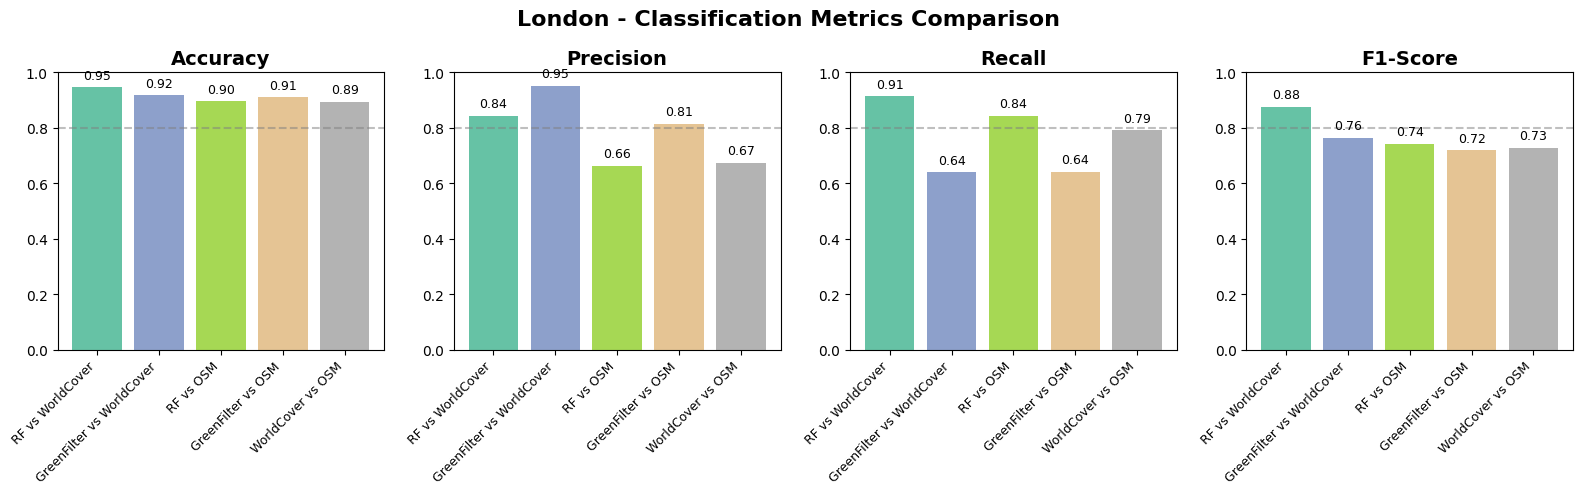

In [32]:
# Metrics Bar Chart
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = plt.cm.Set2(np.linspace(0, 1, len(df_results)))

for i, metric in enumerate(metrics_to_plot):
    bars = axes[i].bar(range(len(df_results)), df_results[metric], color=colors)
    axes[i].set_xticks(range(len(df_results)))
    axes[i].set_xticklabels(df_results['Method'], rotation=45, ha='right', fontsize=9)
    axes[i].set_title(metric, fontsize=14, fontweight='bold')
    axes[i].set_ylim(0, 1)
    axes[i].axhline(y=0.8, color='gray', linestyle='--', alpha=0.5)
    
    # Add value labels
    for bar, val in zip(bars, df_results[metric]):
        axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                    f'{val:.2f}', ha='center', va='bottom', fontsize=9)

plt.suptitle(f'{CITY} - Classification Metrics Comparison', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, 'metrics_barchart.png'), dpi=300, bbox_inches='tight')
plt.show()

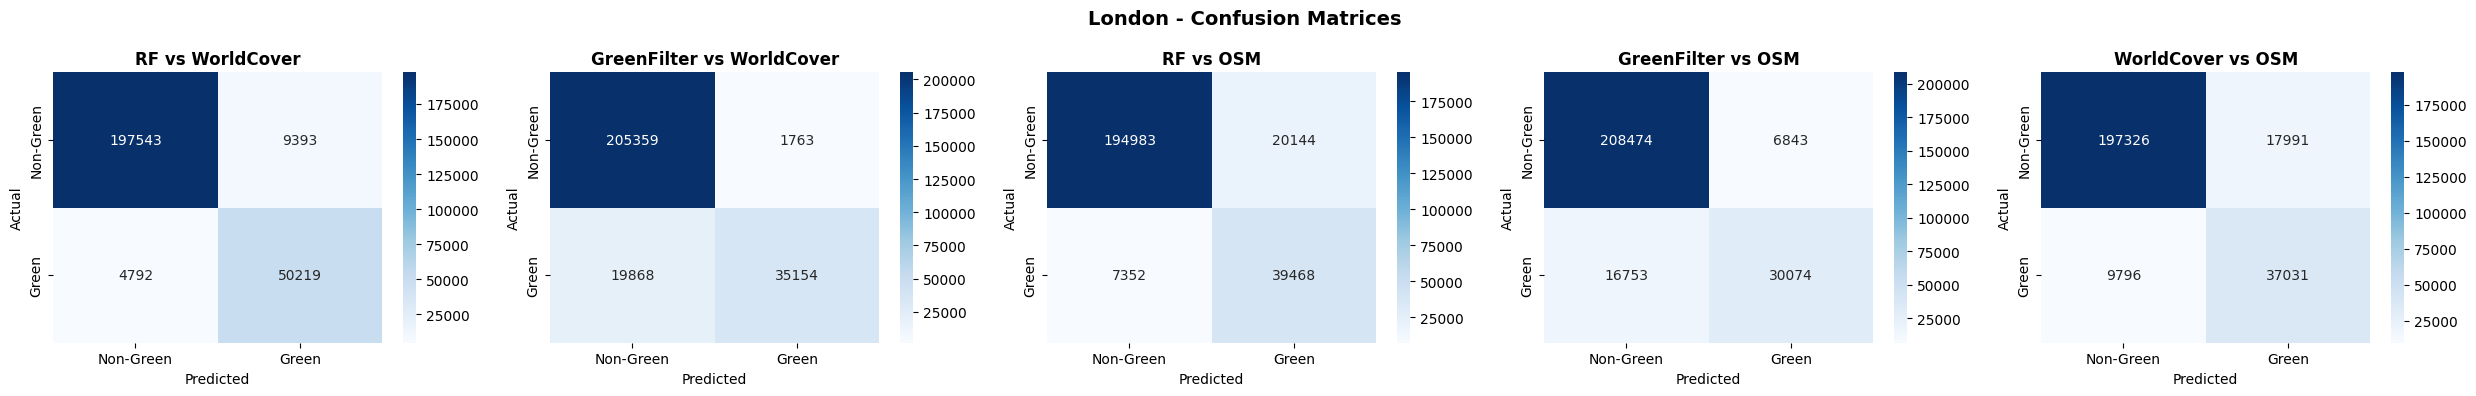

In [33]:
# Confusion Matrices
n_cms = len(confusion_matrices)
fig, axes = plt.subplots(1, n_cms, figsize=(5*n_cms, 4))
if n_cms == 1:
    axes = [axes]

for ax, (name, cm) in zip(axes, confusion_matrices.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Non-Green', 'Green'],
                yticklabels=['Non-Green', 'Green'])
    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.suptitle(f'{CITY} - Confusion Matrices', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, 'confusion_matrices.png'), dpi=300, bbox_inches='tight')
plt.show()

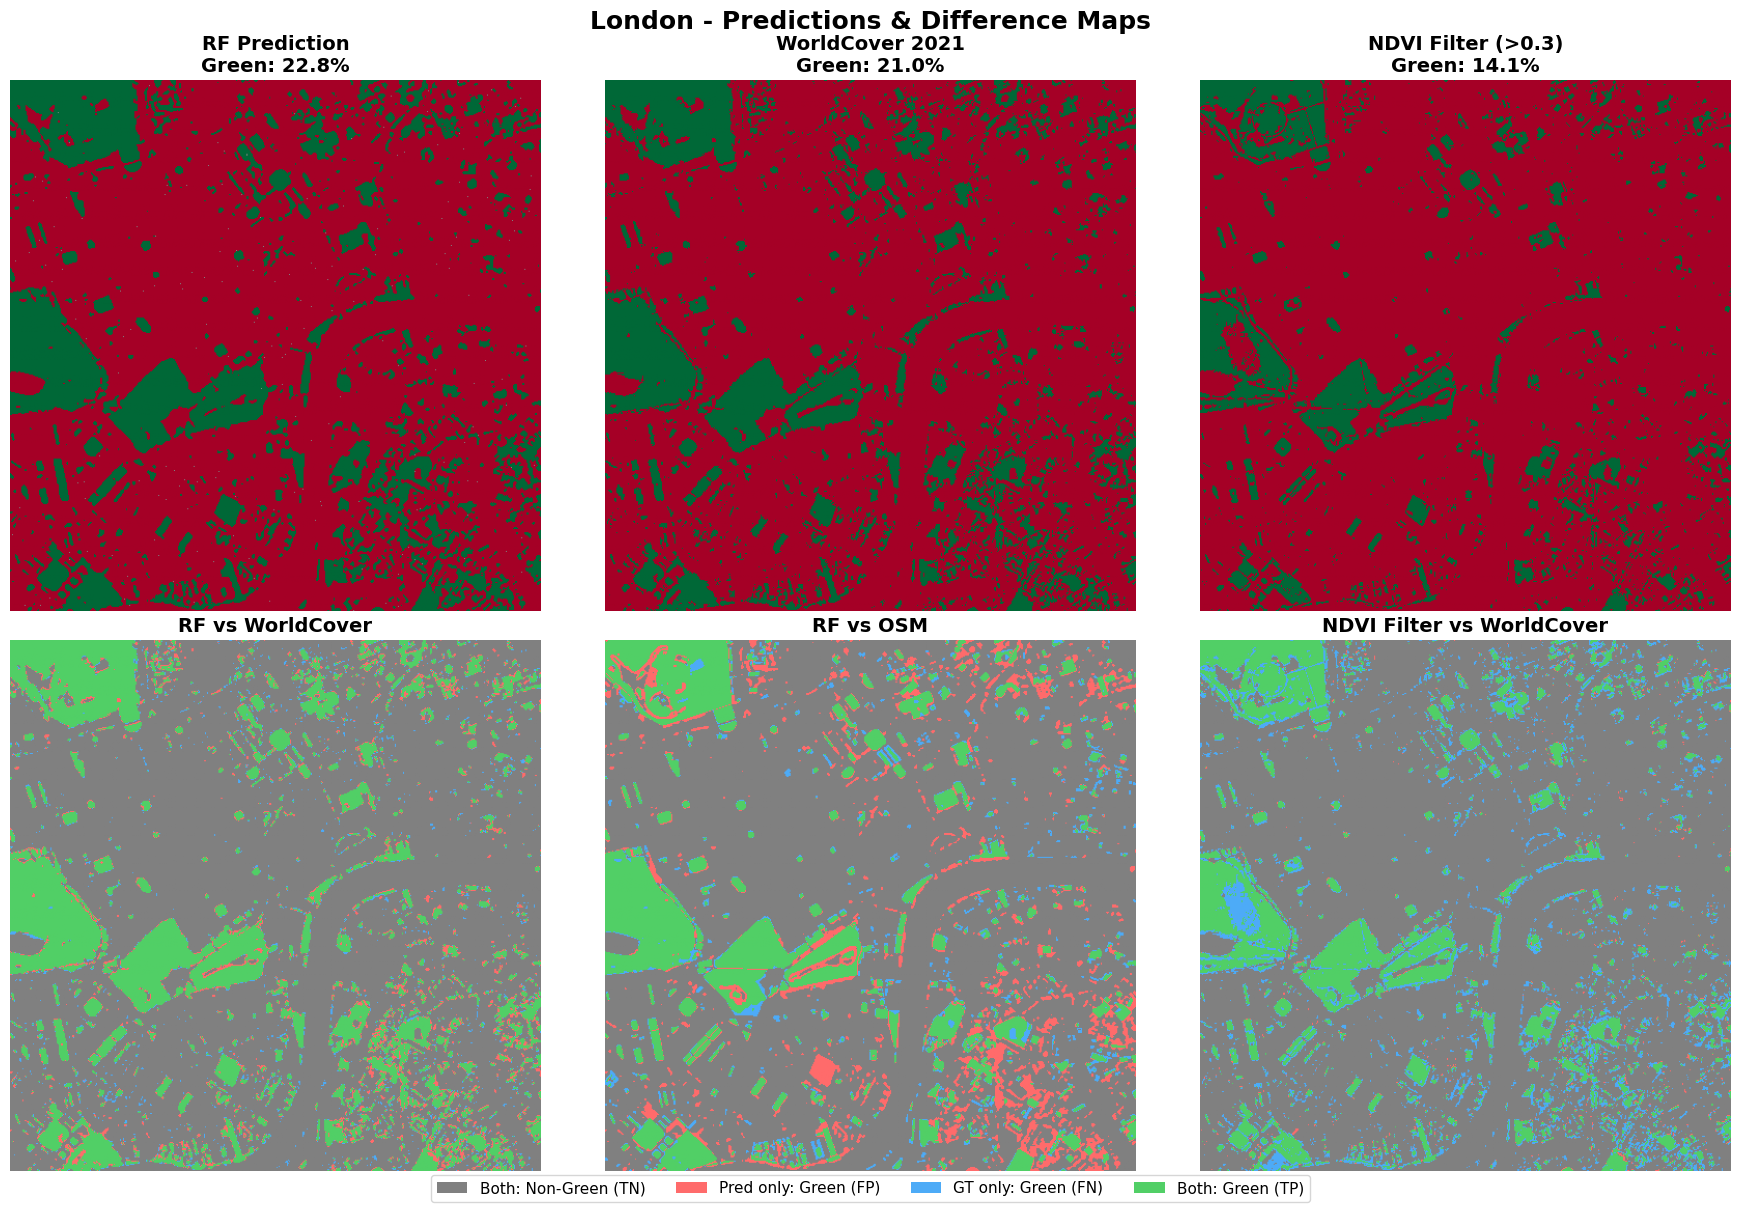

In [34]:
# Detailed Difference Maps - 2 rows x 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Maps
# 1. RF Prediction
axes[0, 0].imshow(rf_masked, cmap=cmap_rf, vmin=0, vmax=1)
axes[0, 0].set_title(f'RF Prediction\nGreen: {rf_pct:.1f}%', fontsize=14, fontweight='bold')
axes[0, 0].axis('off')

# 2. WorldCover
axes[0, 1].imshow(worldcover_green, cmap='RdYlGn', vmin=0, vmax=1)
axes[0, 1].set_title(f'WorldCover 2021\nGreen: {wc_pct:.1f}%', fontsize=14, fontweight='bold')
axes[0, 1].axis('off')

# 3. NDVI Filter
axes[0, 2].imshow(green_filter, cmap='RdYlGn', vmin=0, vmax=1)
axes[0, 2].set_title(f'NDVI Filter (>{NDVI_THRESHOLD})\nGreen: {gf_pct:.1f}%', fontsize=14, fontweight='bold')
axes[0, 2].axis('off')

# Row 2: Difference maps
# 4. RF vs WorldCover
diff_rf_wc = create_diff_map(rf_prediction, worldcover_green)
axes[1, 0].imshow(diff_rf_wc, cmap=diff_cmap, vmin=0, vmax=3)
axes[1, 0].set_title('RF vs WorldCover', fontsize=14, fontweight='bold')
axes[1, 0].axis('off')

# 5. RF vs OSM
if osm_labels is not None:
    diff_rf_osm = create_diff_map(rf_prediction, osm_labels)
    axes[1, 1].imshow(diff_rf_osm, cmap=diff_cmap, vmin=0, vmax=3)
    axes[1, 1].set_title('RF vs OSM', fontsize=14, fontweight='bold')
else:
    axes[1, 1].text(0.5, 0.5, 'OSM not available', ha='center', va='center', 
                    transform=axes[1, 1].transAxes, fontsize=14)
axes[1, 1].axis('off')

# 6. NDVI Filter vs WorldCover
diff_gf_wc = create_diff_map(green_filter, worldcover_green)
axes[1, 2].imshow(diff_gf_wc, cmap=diff_cmap, vmin=0, vmax=3)
axes[1, 2].set_title('NDVI Filter vs WorldCover', fontsize=14, fontweight='bold')
axes[1, 2].axis('off')

# Add legend
legend_elements = [
    Patch(facecolor='#808080', label='Both: Non-Green (TN)'),
    Patch(facecolor='#FF6B6B', label='Pred only: Green (FP)'),
    Patch(facecolor='#4DABF7', label='GT only: Green (FN)'),
    Patch(facecolor='#51CF66', label='Both: Green (TP)')
]
fig.legend(handles=legend_elements, loc='lower center', ncol=4, fontsize=11, bbox_to_anchor=(0.5, -0.02))

plt.suptitle(f'{CITY} - Predictions & Difference Maps', fontsize=18, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, 'predictions_and_diffs.png'), dpi=300, bbox_inches='tight')
plt.show()

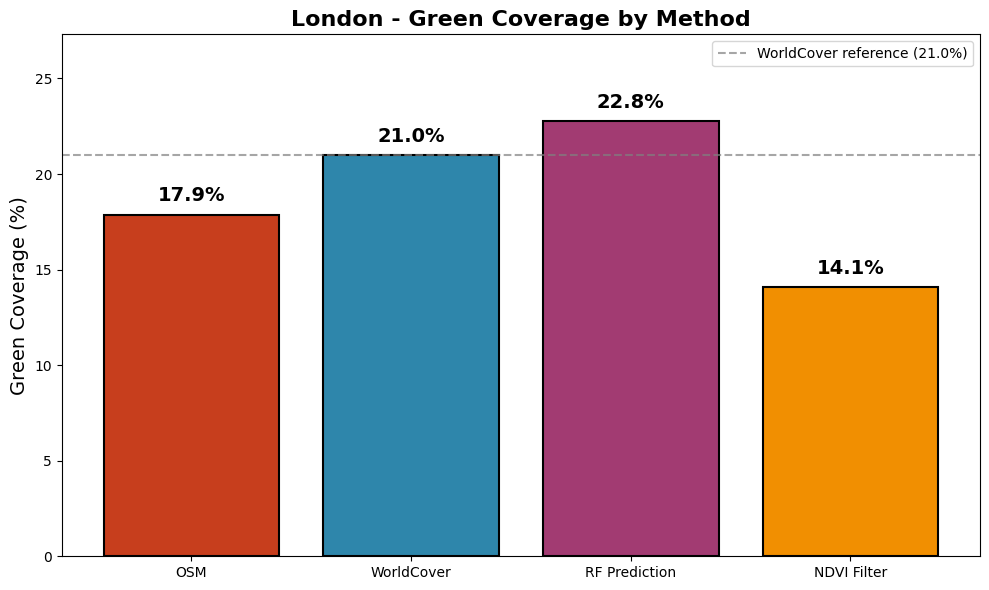

In [35]:
# Green Coverage Summary Bar Chart
fig, ax = plt.subplots(figsize=(10, 6))

methods = ['WorldCover', 'RF Prediction', 'NDVI Filter']
percentages = [wc_pct, rf_pct, gf_pct]
colors = ['#2E86AB', '#A23B72', '#F18F01']

if osm_labels is not None:
    methods.insert(0, 'OSM')
    percentages.insert(0, osm_pct)
    colors.insert(0, '#C73E1D')

bars = ax.bar(methods, percentages, color=colors, edgecolor='black', linewidth=1.5)

# Add value labels
for bar, pct in zip(bars, percentages):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{pct:.1f}%', ha='center', va='bottom', fontsize=14, fontweight='bold')

ax.set_ylabel('Green Coverage (%)', fontsize=14)
ax.set_title(f'{CITY} - Green Coverage by Method', fontsize=16, fontweight='bold')
ax.set_ylim(0, max(percentages) * 1.2)

# Add reference line for WorldCover
ax.axhline(y=wc_pct, color='gray', linestyle='--', alpha=0.7, label=f'WorldCover reference ({wc_pct:.1f}%)')
ax.legend()

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, 'green_coverage_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

## 6. Summary Report

In [36]:
print("="*70)
print(f"EVALUATION SUMMARY - {CITY}")
print("="*70)

print(f"\nGreen Coverage:")
print(f"  WorldCover 2021:    {wc_pct:.2f}%")
print(f"  RF Prediction:      {rf_pct:.2f}% (diff: {rf_pct - wc_pct:+.2f}%)")
print(f"  NDVI Filter:        {gf_pct:.2f}% (diff: {gf_pct - wc_pct:+.2f}%)")
if osm_labels is not None:
    print(f"  OSM Labels:         {osm_pct:.2f}%")

print(f"\nRF vs WorldCover Metrics:")
print(f"  Accuracy:   {metrics_rf_wc['Accuracy']:.4f}")
print(f"  Precision:  {metrics_rf_wc['Precision']:.4f}")
print(f"  Recall:     {metrics_rf_wc['Recall']:.4f}")
print(f"  F1-Score:   {metrics_rf_wc['F1-Score']:.4f}")
print(f"  IoU:        {metrics_rf_wc['IoU (Jaccard)']:.4f}")

print(f"\nOutput Files:")
print(f"  {OUTPUT_FOLDER}/")
print(f"    - metrics_comparison.csv")
print(f"    - comparison_5panel.png")
print(f"    - comparison_vertical.png")
print(f"    - metrics_barchart.png")
print(f"    - confusion_matrices.png")
print(f"    - difference_maps.png")
print(f"    - green_coverage_comparison.png")

print("="*70)

EVALUATION SUMMARY - London

Green Coverage:
  WorldCover 2021:    20.99%
  RF Prediction:      22.76% (diff: +1.77%)
  NDVI Filter:        14.08% (diff: -6.91%)
  OSM Labels:         17.86%

RF vs WorldCover Metrics:
  Accuracy:   0.9458
  Precision:  0.8424
  Recall:     0.9129
  F1-Score:   0.8762
  IoU:        0.7797

Output Files:
  /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/outputs/evaluation_results/London/
    - metrics_comparison.csv
    - comparison_5panel.png
    - comparison_vertical.png
    - metrics_barchart.png
    - confusion_matrices.png
    - difference_maps.png
    - green_coverage_comparison.png


## 7. Agreement Report: RF vs OSM

In [37]:
# Agreement report: RF prediction vs OSM labels across all available cities

# cities that have OSM labels
CITIES_WITH_OSM = ["London", "Melbourne", "Paris", "Seattle", "San_Francisco"]

agreement_rows = []

for city in CITIES_WITH_OSM:
    stack_path = os.path.join(DATA_PATH, "sentinel_stacks", f"{city}_MultiMonth_stack.tif")
    osm_path = os.path.join(DATA_PATH, "sentinel_raw", city, f"{city}_OSM_labels.tif")

    if not os.path.exists(stack_path) or not os.path.exists(osm_path):
        print(f"{city}: missing data, skipping")
        continue

    # load stack
    with rasterio.open(stack_path) as src:
        stack = src.read()
        prof = src.profile.copy()
        tfm = src.transform
        src_crs = src.crs
    nb, h, w = stack.shape

    # load and reproject OSM labels to match stack grid
    with rasterio.open(osm_path) as src:
        osm_raw = src.read(1)
        osm_reproj = np.empty((h, w), dtype=np.uint8)
        reproject(
            source=osm_raw,
            destination=osm_reproj,
            src_transform=src.transform,
            src_crs=src.crs,
            dst_transform=tfm,
            dst_crs=src_crs,
            resampling=Resampling.nearest
        )

    # RF prediction
    X_flat = stack.reshape(nb, -1).T
    valid = ~np.isnan(X_flat).any(axis=1)
    X_v = X_flat[valid]
    X_vs = scaler.transform(X_v)
    proba = model.predict_proba(X_vs)
    pred_valid = (proba[:, 1] >= PREDICTION_THRESHOLD).astype(int)

    rf_map = np.full(h * w, np.nan)
    rf_map[valid] = pred_valid
    rf_map = rf_map.reshape(h, w)

    # smoothing
    nan_m = np.isnan(rf_map)
    tmp = np.where(nan_m, 0, rf_map).astype(np.float32)
    tmp_f = median_filter(tmp, size=3)
    rf_map = np.where(nan_m, np.nan, np.round(tmp_f))

    # flatten and keep only valid pixels
    rf_flat = rf_map.flatten()
    osm_flat = osm_reproj.flatten().astype(float)
    mask = ~np.isnan(rf_flat)
    rf_c = rf_flat[mask].astype(int)
    osm_c = osm_flat[mask].astype(int)
    total = len(rf_c)

    both_green = int(np.sum((rf_c == 1) & (osm_c == 1)))
    both_nongreen = int(np.sum((rf_c == 0) & (osm_c == 0)))
    rf_only = int(np.sum((rf_c == 1) & (osm_c == 0)))
    osm_only = int(np.sum((rf_c == 0) & (osm_c == 1)))
    total_agree = both_green + both_nongreen

    agreement_rows.append({
        "City": city,
        "Total pixels": total,
        "Both green (%)": round(100 * both_green / total, 2),
        "Both non-green (%)": round(100 * both_nongreen / total, 2),
        "RF only green (%)": round(100 * rf_only / total, 2),
        "OSM only green (%)": round(100 * osm_only / total, 2),
        "Total agreement (%)": round(100 * total_agree / total, 2),
    })

    print(f"{city}: agreement {100 * total_agree / total:.1f}%")

df_agreement = pd.DataFrame(agreement_rows)
print("\n")
print(df_agreement.to_string(index=False))

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    1.5s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    1.6s finished


London: agreement 89.5%


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    1.6s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    1.7s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.


Melbourne: agreement 86.8%


[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    1.5s finished


Paris: agreement 90.9%


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    1.4s
[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    1.5s finished


Seattle: agreement 81.3%


[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.3s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    1.6s


San_Francisco: agreement 91.9%


         City  Total pixels  Both green (%)  Both non-green (%)  RF only green (%)  OSM only green (%)  Total agreement (%)
       London        261947           15.07               74.44               7.69                2.81                89.50
    Melbourne        262017           15.07               71.75               9.35                3.83                86.82
        Paris        261961            6.91               83.97               5.63                3.49                90.88
      Seattle        262045            4.54               76.77              16.23                2.47                81.30
San_Francisco        261979            4.43               87.49               5.90                2.18                91.92


[Parallel(n_jobs=10)]: Done 200 out of 200 | elapsed:    1.8s finished


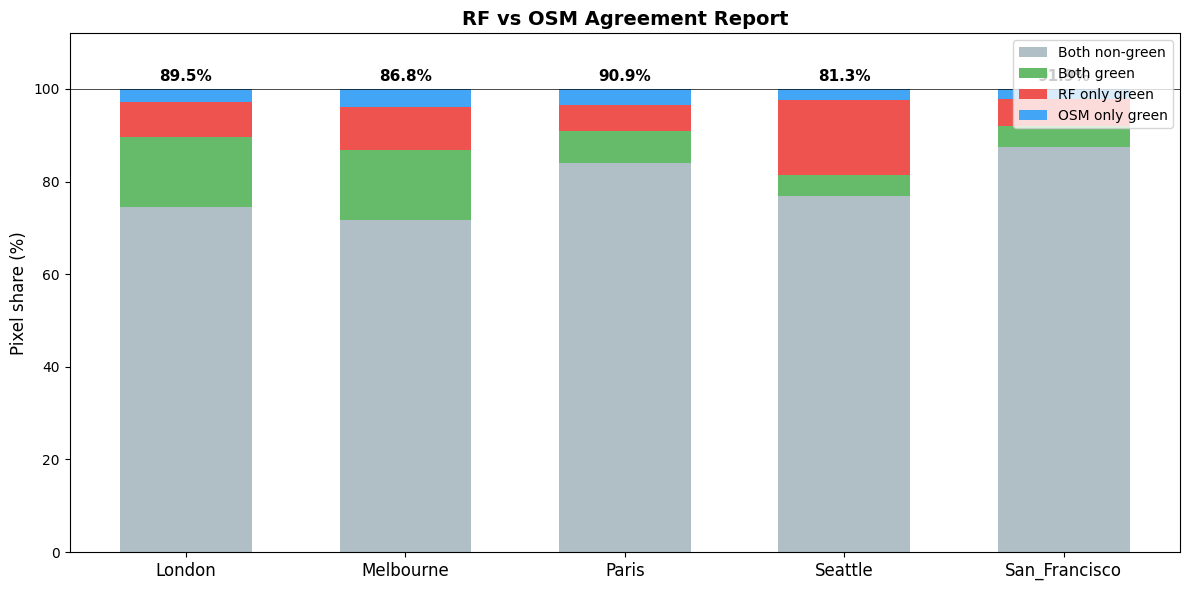

Agreement report saved to /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/outputs/evaluation_results/London/rf_osm_agreement.csv


In [38]:
# Visualisation: stacked bar chart of agreement breakdown per city
fig, ax = plt.subplots(figsize=(12, 6))

cities_list = df_agreement["City"].tolist()
x = np.arange(len(cities_list))
bar_w = 0.6

both_g = df_agreement["Both green (%)"].values
both_ng = df_agreement["Both non-green (%)"].values
rf_o = df_agreement["RF only green (%)"].values
osm_o = df_agreement["OSM only green (%)"].values

b1 = ax.bar(x, both_ng, bar_w, label="Both non-green", color="#B0BEC5")
b2 = ax.bar(x, both_g, bar_w, bottom=both_ng, label="Both green", color="#66BB6A")
b3 = ax.bar(x, rf_o, bar_w, bottom=both_ng + both_g, label="RF only green", color="#EF5350")
b4 = ax.bar(x, osm_o, bar_w, bottom=both_ng + both_g + rf_o, label="OSM only green", color="#42A5F5")

# annotate total agreement on top
for i, row in df_agreement.iterrows():
    ax.text(i, 101, f'{row["Total agreement (%)"]:.1f}%',
            ha="center", va="bottom", fontsize=11, fontweight="bold")

ax.set_xticks(x)
ax.set_xticklabels(cities_list, fontsize=12)
ax.set_ylabel("Pixel share (%)", fontsize=12)
ax.set_ylim(0, 112)
ax.set_title("RF vs OSM Agreement Report", fontsize=14, fontweight="bold")
ax.legend(loc="upper right", fontsize=10)
ax.axhline(y=100, color="black", linewidth=0.5)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_FOLDER, "rf_osm_agreement.png"), dpi=300, bbox_inches="tight")
plt.show()

# save table
df_agreement.to_csv(os.path.join(OUTPUT_FOLDER, "rf_osm_agreement.csv"), index=False)
print(f"Agreement report saved to {OUTPUT_FOLDER}/rf_osm_agreement.csv")